# Big data in xarray 

In [Intake_tutorial](Intake_tutorial.ipynb), we explored the data available in the ACCESS-NRI Intake catalog and open some data for analysis. We did this using xarray datasets, and you may notice when you inspect these they don't show any data, only [dask](https://docs.xarray.dev/en/stable/user-guide/dask.html) objects. 

The traditional way of opening data (and for example would be done by using _numpy_ python library directly), is to load the data into RAM when opening the data. When handling big data, this method breaks down, as the data is larger than the available RAM. Natively Python is not multi-threaded, and therefore runs on one CPU only.

Dask divides arrays into many small pieces, called _chunks_, which are small enough to fit into memory. Operations on the array are mapped over each relevant chunk, allowing each chunk to be processed by a different processor. Completion of the calculation for each operation is done lazily, i.e. only once the actual result of the calculation is needed. This means  that only the needed chunks for a calculation are loaded into memory, and each chunk can be evaluated on a different processor. 

The https://docs.xarray.dev/en/stable/user-guide/dask.html user guide is a useful starting point to understand this better

We are going to explore this through some examples

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [2]:
import intake

catalog = intake.cat.access_nri

In [3]:
from distributed import Client

client = Client(threads_per_worker=1)

In [4]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 12
Total threads: 12,Total memory: 46.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46467,Workers: 12
Dashboard: /proxy/8787/status,Total threads: 12
Started: Just now,Total memory: 46.00 GiB
Comm: tcp://127.0.0.1:45281,Total threads: 1
Dashboard: /proxy/42233/status,Memory: 3.83 GiB
Nanny: tcp://127.0.0.1:39935,


For example, if we look at sea surface temperature from ACCESS-OM2. 

In [5]:
%%time
sst_ds = catalog['025deg_jra55_iaf_omip2_cycle6'].search(variable='sst', frequency='1mon').to_dask()

CPU times: user 6.25 s, sys: 3.79 s, total: 10 s
Wall time: 32.7 s


In [6]:
sst_ds.sst

<xarray.DataArray 'sst' (time: 732, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
dask.array<concatenate, shape=(732, 1080, 1440), dtype=float32, chunksize=(1, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Attributes:
    long_name:      Potential temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

Even though there is 4GB of data there, it opened very fast - about a second. This is becuase the data is loaded 'lazily'. The `to_dask` function uses xarray under the covers, and xarray here has loaded only the coordinates (x,y,time) into memory, and just enough information that it could load `sst` if needed.

It is available to do operations on, and is basically silent to the user its been loaded lazily. e.g. we can analyze and plot, In our example we will calculated global SST (by weighting the SST in each cell by the area of the cell).

In [39]:
grid = xr.load_dataset(catalog['025deg_jra55_iaf_omip2_cycle6'].search(variable='area_t').df.path[0])

areat = grid.area_t.fillna(0)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 13.84 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 1min 24s, sys: 8.29 s, total: 1min 32s
Wall time: 1min 37s


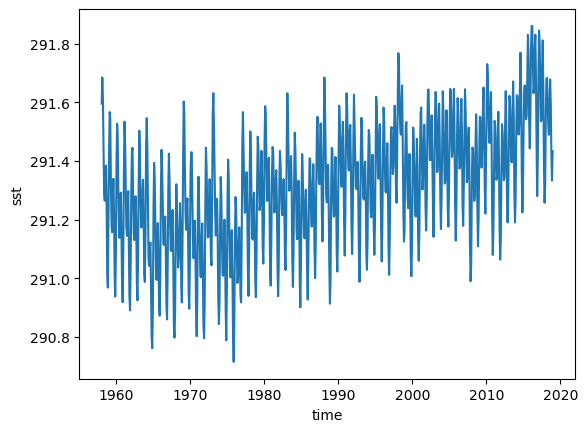

In [8]:
%%time
sst_ds.sst.weighted(areat).mean(['xt_ocean','yt_ocean']).plot()
#To account for variation in cell area, sst is weighted by cell area in a global mean

Our dataset is small enough it could fit in memory, so we could just load it when we open it. This takes longer to open but might be faster then to analyse.

In [9]:
%%time
sst_ds.load()

CPU times: user 31.6 s, sys: 11.1 s, total: 42.7 s
Wall time: 47.8 s


<xarray.Dataset> Size: 5GB
Dimensions:   (time: 732, yt_ocean: 1080, xt_ocean: 1440)
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Data variables:
    sst       (time, yt_ocean, xt_ocean) float32 5GB nan nan nan ... nan nan nan
Attributes: (12/16)
    filename:                                 ocean_month.nc
    title:                                    ACCESS-OM2
    grid_type:                                mosaic
    grid_tile:                                1
    intake_esm_vars:                          ['sst']
    intake_esm_attrs:realm:                   ocean
    ...                                       ...
    intake_esm_attrs:variable_cell_methods:   time: mean,time: mean,time: mea...
    intake_esm_attrs:variable_units:          dbar,Pa,(kg/m^3)*m,m,meter,m^2,...
    intake_esm_attrs:filename:                ocean_month.nc
    intake_esm_attrs:file_id:                 ocean_month
    intake_esm_attrs:_data_format_:           netcdf
    intake_esm_dataset_key:                   ocean_month.1mon

Now when we inspect the dataset, it shows us the data because we have loaded it already

In [10]:
sst_ds.sst

<xarray.DataArray 'sst' (time: 732, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Attributes:
    long_name:      Potential temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

Now when we do this weighted mean calculation, it only uses one python task - it is not distributed across the available processors. 

CPU times: user 45.6 s, sys: 10.1 s, total: 55.7 s
Wall time: 43.4 s


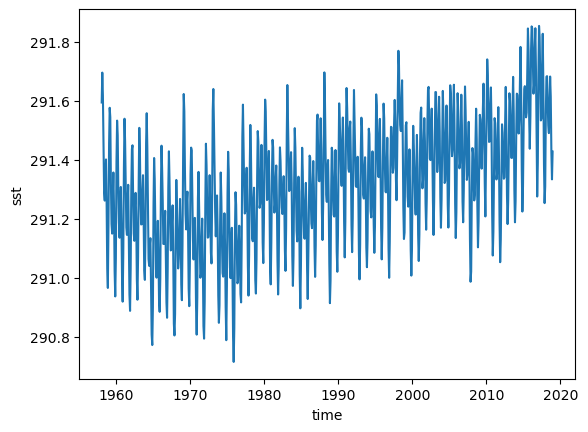

In [11]:
%%time
sst_ds.sst.weighted(areat).mean(['xt_ocean','yt_ocean']).plot()

The overall run time to plot loading the weighted mean is faster than using dask. As our dataset fits in RAM, this is possible, and the overhead associated with distributing the work across tasks doesn't appear to pay off in faster calculation times from using more processors.


However by digging a bit more how we access the data, we can do better.

In [12]:
del sst_ds

Our source data (in netcdf format) has chunks defined in it. These are intial chunksizes set also in the xarray DataArray. You can see the chunks are 1 step in time, 216 steps in y and 240 steps in x. The size in memory of these chunks is very small (203kB) and much smaller than the ram available per processor (typically 2.5-4GB at NCI, depending on the queue used). A rule of thumb for chunk sizes is to aim for chunk sizes about 10% of the memory available to the processer (memory to the dask worker, to be precise).

We are going to rechunk in a way that only combines existing chunks, and does not split any chunks. Splitting chunks would lead to them being read from disk more than once.

To do a simple mean in x & y, we want to load all x and all y in the same chunk.

In [33]:
%%time
sst_ds = catalog['025deg_jra55_iaf_omip2_cycle6'].search(variable='sst', frequency='1mon').to_dask(
    xarray_open_kwargs={'chunks':{'yt_ocean':-1,'xt_ocean':-1}}
)

CPU times: user 36 s, sys: 31.2 s, total: 1min 7s
Wall time: 32.5 s


Note that supplying the chunks when opening, is more efficient than using the `chunks` function after opening the dataset. However the chunksize is limited to the amount of data in each source netcdf file. In this case, we can't open the source data with chunksizes in time of larger than 1.

In [34]:
sst_ds.sst

<xarray.DataArray 'sst' (time: 732, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
dask.array<concatenate, shape=(732, 1080, 1440), dtype=float32, chunksize=(1, 1080, 1440), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Attributes:
    long_name:      Potential temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

CPU times: user 6.47 s, sys: 1.32 s, total: 7.79 s
Wall time: 10.2 s


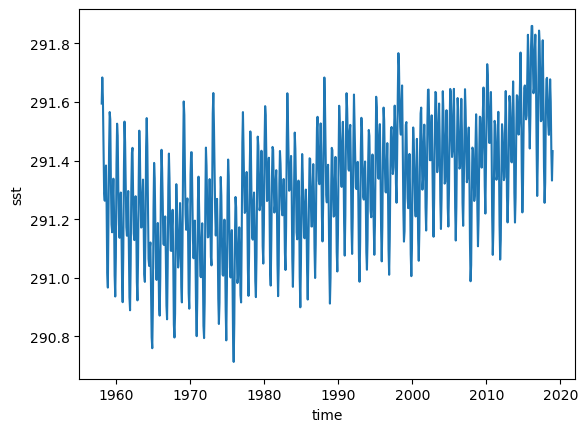

In [15]:
%%time
sst_ds.sst.weighted(areat).mean(['xt_ocean','yt_ocean']).plot()

This is our fastest plot yet! 

Question for the group - why would this be a bad idea?

```python

sst_badchunk = sst_ds.sst.chunk({'yt_ocean':1,'xt_ocean':1, 'time':-1})

sst_badchunk.mean(['xt_ocean','yt_ocean']).plot()
```
Don't try this, the kernal crashes.

A couple more examples of what not to do...

The next two cells are mathematically equivalent, but less efficient and harder to understand than using built-in xarray methods

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/distributed/client.py:3357: UserWarning: Sending large graph of size 12.14 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


CPU times: user 4.56 s, sys: 1.52 s, total: 6.08 s
Wall time: 9.93 s


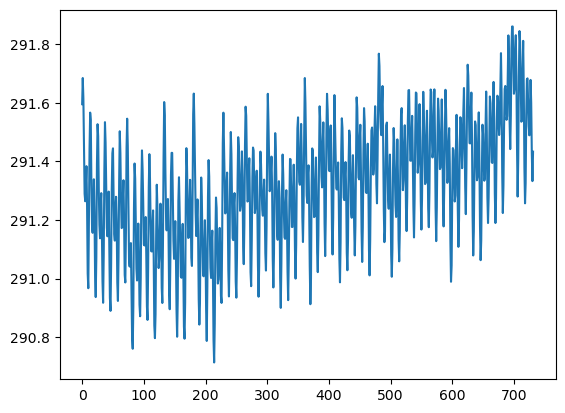

In [16]:
%%time

weighted_sum = np.sum((sst_ds.sst * areat), axis=(1,2))
areat_sum=np.sum(areat.where(~sst_ds.sst.isel(time=0).isnull())) #remove nans

glob_sst = weighted_sum/areat_sum

plt.plot(glob_sst)

We can do the same calculate using a for loop. This result is especially bad because it converts to a in-memory numpy array at an earlier step and does not distribute the work.

CPU times: user 1min 24s, sys: 29.4 s, total: 1min 54s
Wall time: 3min 17s


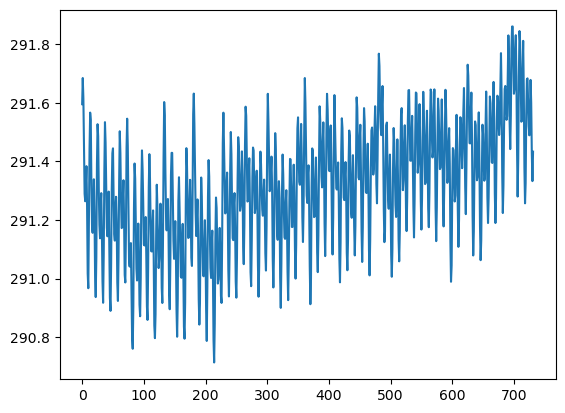

In [17]:
%%time

sst = sst_ds.sst.values

mean = np.zeros(len(sst))

for i in range(0,len(sst)):
    mean[i] = np.sum(sst[i,:,:]*areat)/areat_sum

plt.plot(mean)

To recap, we achieved the fastest performance by aligning chunks to the operation we are performing. Therefore for a mean in x,y we want our chunks as large as possible in x,y. 

It is harder to optimise for calculations in time, because our source data has chunkszies in time of 1 timestep. First reset to the default chunks:

In [18]:
%%time
sst_ds = catalog['025deg_jra55_iaf_omip2_cycle6'].search(variable='sst', frequency='1mon').to_dask()

CPU times: user 1.41 s, sys: 336 ms, total: 1.75 s
Wall time: 2.34 s


CPU times: user 39.9 s, sys: 5.36 s, total: 45.2 s
Wall time: 46.8 s


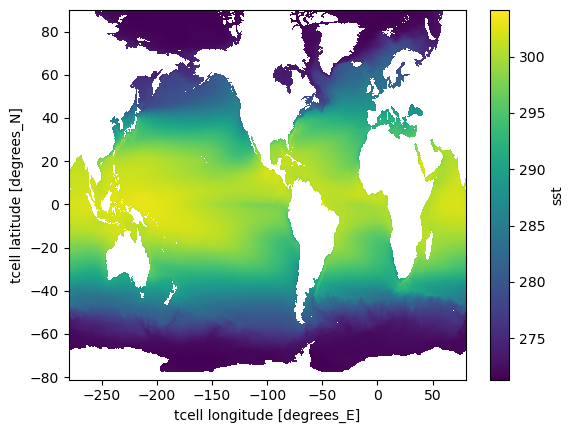

In [19]:
%%time
sst_ds.sst.mean(['time']).plot()
#n.b. to do this correctly we should include the real latitude and longitude, note the plots are skewed north of 65°N

We can combine the chunks, but this adds to the dask workload:

In [20]:
sst_ds.sst.chunk({'time':-1})

<xarray.DataArray 'sst' (time: 732, yt_ocean: 1080, xt_ocean: 1440)> Size: 5GB
dask.array<rechunk-merge, shape=(732, 1080, 1440), dtype=float32, chunksize=(732, 216, 240), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 12kB -279.9 -279.6 -279.4 ... 79.38 79.62 79.88
  * yt_ocean  (yt_ocean) float64 9kB -81.08 -80.97 -80.87 ... 89.74 89.84 89.95
  * time      (time) datetime64[ns] 6kB 1958-01-14T12:00:00 ... 2018-12-14T12...
Attributes:
    long_name:      Potential temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_surface_temperature

The memory needs of our chunks are already in the ballpark (145MB, so there's no utility in opening with x & y arguments for chunksize)

CPU times: user 24.1 s, sys: 2.87 s, total: 27 s
Wall time: 29.3 s


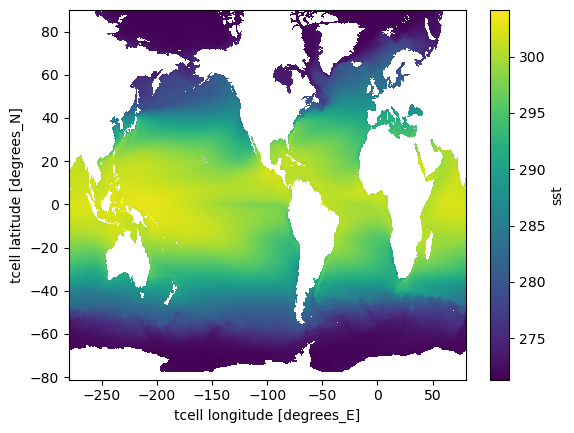

In [21]:
%%time
sst_ds.sst.chunk({'time':-1}).mean(['time']).plot()

This gives us a small speedup - maybe 20seconds.

Some things to consider when setting chunksizes:

- Too small means too many tasks are needed which are inefficient
- Too big mean they won't fit in memory of an individual worker, and maybe end up getting read and written from disk excessively or just crashing
- Chunks aligned to the analysis are faster

## Scaling up

In [22]:
temp_ds = catalog['01deg_jra55v140_iaf_cycle4'].search(variable='temp').to_dask()

In [23]:
temp_ds.temp

<xarray.DataArray 'temp' (time: 732, st_ocean: 75, yt_ocean: 2700,
                          xt_ocean: 3600)> Size: 2TB
dask.array<concatenate, shape=(732, 75, 2700, 3600), dtype=float32, chunksize=(1, 19, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * st_ocean  (st_ocean) float64 600B 0.5413 1.681 2.94 ... 5.511e+03 5.709e+03
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature

In [24]:
sst_ds=temp_ds.isel(st_ocean=0, drop=True)

In [25]:
sst_ds.temp

<xarray.DataArray 'temp' (time: 732, yt_ocean: 2700, xt_ocean: 3600)> Size: 28GB
dask.array<getitem, shape=(732, 2700, 3600), dtype=float32, chunksize=(1, 135, 180), chunktype=numpy.ndarray>
Coordinates:
  * xt_ocean  (xt_ocean) float64 29kB -279.9 -279.8 -279.7 ... 79.75 79.85 79.95
  * yt_ocean  (yt_ocean) float64 22kB -81.11 -81.07 -81.02 ... 89.89 89.94 89.98
  * time      (time) datetime64[ns] 6kB 1958-01-16T12:00:00 ... 2018-12-16T12...
Attributes:
    long_name:      Conservative temperature
    units:          K
    valid_range:    [-10. 500.]
    cell_methods:   time: mean
    time_avg_info:  average_T1,average_T2,average_DT
    standard_name:  sea_water_conservative_temperature

In [26]:
areat = xr.open_dataset(
    catalog['01deg_jra55v140_iaf_cycle4'].search(variable='area_t').df.path[0]
).area_t.fillna(0)

From the results above, whats the best way to handle this data set? For a mean in time, and for a mean in space ?

As a baseline, running 

```python
%%time
sst_ds.temp.weighted(areat).mean(['xt_ocean','yt_ocean']).plot()
```
took 20 minutes on a large gadi instance.

In [41]:
client.close()